In [1]:
%%writefile HexVectorizer.py

from sklearn.feature_extraction.text import CountVectorizer

import os
import re

# Byte file properties
LINE_LEN = 16
ADDR_LEN = 9


def hex_to_str(hex_line):
    """
    Function to strip \r, \n and remove address
    of length eight character+space from hex line.
    """
    return hex_line.decode().strip()[ADDR_LEN:]


def remove_non_hex(hex_str):
    """
    Function to remove non hex characters.
    """
    # Replace non hex characters with empty string.
    hex_str = re.sub(r"[^0-9A-F\s]+", "", hex_str, flags=re.IGNORECASE)
    # Replace multiple spaces with single space.
    hex_str = re.sub(r"\s+", " ", hex_str)

    return hex_str.strip().lower()


class Vectorizer(CountVectorizer):
    """
    Convert strings to vectors
    """

    def transform_byte_file(self, ts_file):
        """
        Function to convert a byte-file into a data-point/row in CSV file.
        Each data-point will have file-name, file-size & byte-string columns.
        """

        # Open the byte-file for reading.
        with open(ts_file, "rb") as byt_f:
            # Remove memory address in the beginning of each line and concatenate
            # all lines in the byte-file into a single string separated by space.
            byt_str = " ".join([hex_to_str(line) for line in byt_f.readlines()])
            byt_str = remove_non_hex(byt_str)

            # Get the byte-file name.
            f_path, _ = os.path.splitext(byt_f.name)  # Full path, extension.
            _, f_name = f_path.rsplit("/", 1)  # Relative path, file-name.

            # Get the byte-file size.
            file_info = os.stat(byt_f.name)
            f_size = file_info.st_size

            bow = self.transform([byt_str]).toarray()[0].tolist()
            return [f_name, f_size] + bow

    def get_feature_names(self):
        """
        Function to return vocabulary as feature names.
        """
        return self.get_feature_names_out().tolist()

Writing HexVectorizer.py


In [2]:
# Data manipulation libraries.
import numpy as np
import pandas as pd

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Data modeling libraries.
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

# General Imports
import os
import csv
import re
import time
import math
from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool

# Custom modules
from HexVectorizer import Vectorizer


# Library versions.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130
# pd.options.display.max_rows = None  # Very dangerous! if dataset is large.

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.6
Pandas version: 1.3.5
Matplotlib version: 3.5.3
Seaborn version: 0.11.2
Scikit-learn version: 1.0.2


In [3]:
TRAIN_DIR = "../input/malware-classification/train/"
LABELS_CSV = "../input/malware-classification/trainLabels.csv"
TEST_DIR = "../input/malware-classification/test/"
PREPS_DIR = "../input/microsoft-malware-sample/"
BYTE_EXT = ".bytes"

BAL_CL_CSV = os.path.join(PREPS_DIR, "trainLabels_bal.csv")
TR_VEC_CSV = os.path.join(PREPS_DIR, "train_vec.csv")
TS_VEC_CSV = os.path.join(PREPS_DIR, "test_vec.csv")

# Byte file properties
LINE_LEN = 16
ADDR_LEN = 9


# Malware class-labels.
MALWARE_CLS = {
    1: "Ramnit",
    2: "Lollipop",
    3: "Kelihos_ver3",
    4: "Vundo",
    5: "Simda",
    6: "Tracur",
    7: "Kelihos_ver1",
    8: "Obfuscator.ACY",
    9: "Gatak",
}
mw_codes = lambda: list(MALWARE_CLS.keys())
mw_names = lambda: list(MALWARE_CLS.values())


SAMPLE_SIZE = 200  # Number of samples taken from each class.
# Function to pick random sample of size SAMPLE_SIZE from each class.
get_sample = lambda grp: grp.sample(min(SAMPLE_SIZE, len(grp)))


def get_weights(cls):
    class_weights = {
        0: 1,
        1: 1,
        2: 1,
        3: 1,
        4: 4,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
    }

    return [class_weights[cl] for cl in cls]

In [4]:
# Multiprocessing on Jupyter Notebook on windows:
# https://stackoverflow.com/a/47374811/5070460
def parallelize(task, data):
    """
    Function to parallelize `task()` for list of items passed as `data`.
    """
    # Confirm that the code is under main function.
    if __name__ == "__main__":
        # Set pool size to number of logical-processors available.
        POOL_SIZE = multiprocessing.cpu_count()
        pool = Pool(processes=POOL_SIZE)
        print("Pool size:", POOL_SIZE)

        outputs = []
        pbar = tqdm(total=len(data))
        for output in pool.imap_unordered(task, data):
            outputs.append(output)
            pbar.update()
        pbar.close()

        return outputs

In [5]:
# Class-labels DataFrame.
cl_df = pd.read_csv(LABELS_CSV)
cl_df.head()

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


In [6]:
rows, cols = cl_df.shape
print(f"There are around {rows} malware files available in the Train dataset.")

There are around 10868 malware files available in the Train dataset.


In [7]:
cls_count = cl_df["Class"].value_counts().sort_index()
cls_count

1    1541
2    2478
3    2942
4     475
5      42
6     751
7     398
8    1228
9    1013
Name: Class, dtype: int64

In [8]:
if os.path.exists(BAL_CL_CSV) and os.stat(BAL_CL_CSV).st_size > 0:
    cl_df_b = pd.read_csv(BAL_CL_CSV)
else:
    cl_df_b = cl_df.groupby("Class", group_keys=False).apply(get_sample)
    # Save DataFrame as CSV for future use.
    cl_df_b.to_csv(BAL_CL_CSV, index=False)

rows, cols = cl_df_b.shape
print(f"Balanced subset will contain data of {rows} byte-files.")

cls_count = cl_df_b["Class"].value_counts().sort_index()

Balanced subset will contain data of 1642 byte-files.


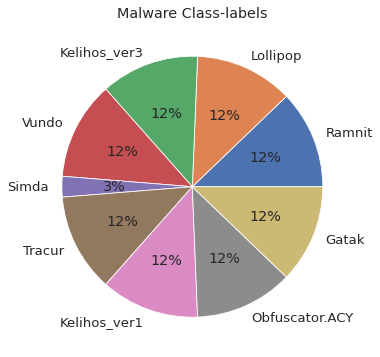

In [9]:
plt.figure(figsize=(6, 6))

plt.pie(x=cls_count, labels=mw_names(), autopct="%1.0f%%")
plt.title("Malware Class-labels")

plt.show()

In [10]:
hex_chars = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "a", "b", "c", "d", "e", "f"]

vectorizer = Vectorizer()
vectorizer.vocabulary = [f"{i}{j}" for i in hex_chars for j in hex_chars]

In [11]:
final_ftrs = ["Id", "BytFSize"] + vectorizer.get_feature_names()
file_paths = [os.path.join(TRAIN_DIR, Id) + BYTE_EXT for Id in cl_df_b["Id"]]
file_count = len(file_paths)

print(f"Select {file_count} byte-files from unzipped files for processing.")

if os.path.exists(TR_VEC_CSV) and os.stat(TR_VEC_CSV).st_size > 0:
    print("Sample is already vectorized in:", TR_VEC_CSV)
    train_df = pd.read_csv(TR_VEC_CSV)
else:
    print("Vectorization of balanced sample from original dataset...")

    # Parallelized File Processing.
    tr_ftr_vecs = parallelize(vectorizer.transform_byte_file, file_paths)

    # Convert vectors to DataFrame.
    train_df = pd.DataFrame(tr_ftr_vecs, columns=final_ftrs)

    def get_class(Id):
        fltr = cl_df_b["Id"] == Id
        return cl_df_b.loc[fltr, "Class"].item()

    # Append class labels.
    train_df["Class"] = train_df["Id"].apply(get_class)

    # Save DataFrame as CSV for future use.
    train_df.to_csv(TR_VEC_CSV, index=False)

Select 1642 byte-files from unzipped files for processing.
Sample is already vectorized in: ../input/microsoft-malware-sample/train_vec.csv


In [12]:
train_df.sample(5)

,Id,BytFSize,00,01,02,03,04,05,06,07,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,Class
1521,DCZeMryOtKQxBgW58UYo,623616,19540,1304,463,329,1077,1101,1076,349,...,394,302,295,10848,310,326,345,413,6910,9
1319,EC32VKxBYp8ckZl5joqb,460288,25406,707,209,398,547,334,181,168,...,503,866,646,669,745,1070,479,390,3335,8
1578,C1eapL4ozVSUfj9NKDA8,4528640,611878,2819,2543,2588,2682,2865,2463,2352,...,2397,2588,2473,2295,2391,2635,2344,2476,3903,9
624,DRsZqtFbzNrucxWaJofL,222720,2148,102,87,245,437,92,80,99,...,123,97,84,78,105,143,112,106,364,4
685,loIP1tiwELF9YNZQjSUO,2331136,5268,1177,1072,1222,1238,1159,1143,1126,...,1218,1125,1094,1154,1088,1113,1114,1107,1178,4


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Columns: 259 entries, Id to Class
dtypes: int64(258), object(1)
memory usage: 3.2+ MB


In [14]:
rows, cols = train_df.shape
print(f"Dataset contains {rows} rows and {cols} columns")

Dataset contains 1642 rows and 259 columns


In [15]:
for uid, cl in train_df[["Id", "Class"]].values:
    fltr = (cl_df["Id"] == uid) & (cl_df["Class"] == cl)
    f_id = cl_df.loc[fltr, "Id"]
    if f_id.empty:
        raise ValueError(f"Id: {uid} with class: {cl} not found in cl_df.")

print("All file-ids and class-labels are matching.")

All file-ids and class-labels are matching.


### 5.2 Feature Scaling

In [16]:
X = train_df.drop(["Id", "Class"], axis=1)
y = train_df["Class"]

# Centering data-points.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# import warnings
# warnings.filterwarnings("ignore")

tsne = TSNE(
    n_components=2,
    perplexity=10,
    init="random",
    learning_rate="auto",
    verbose=1,
    random_state=42,
    n_jobs=-1,
)
z = tsne.fit_transform(X_scaled)
kld = np.round(tsne.kl_divergence_, 4)

print("KL-Divergence:", kld)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1642 samples in 0.001s...
[t-SNE] Computed neighbors for 1642 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1642
[t-SNE] Computed conditional probabilities for sample 1642 / 1642
[t-SNE] Mean sigma: 0.062009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.989677
[t-SNE] KL divergence after 1000 iterations: 0.704136
KL-Divergence: 0.7041


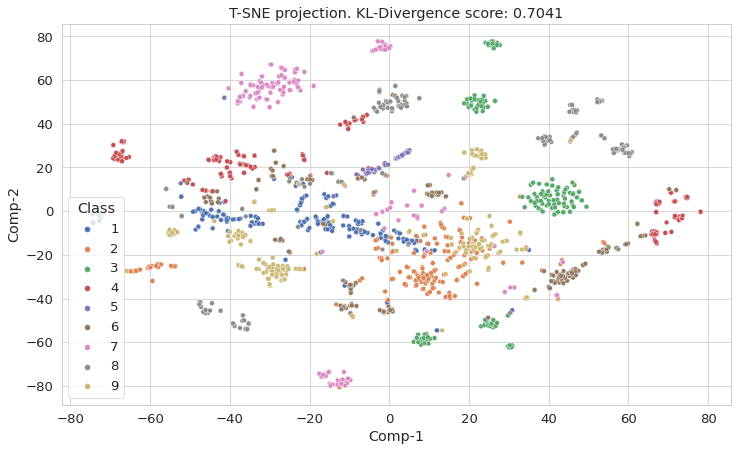

In [18]:
df = pd.DataFrame()

df["Class"] = y.astype("category")
df["Comp-1"] = z[:, 0]
df["Comp-2"] = z[:, 1]

plt.figure(figsize=(12, 7))

sns.scatterplot(data=df, x="Comp-1", y="Comp-2", hue="Class")
plt.title(f"T-SNE projection. KL-Divergence score: {kld}")
plt.show()

In [19]:
le = LabelEncoder()
y = le.fit_transform(y)

In [20]:
X_train, X_cval, y_train, y_cval = train_test_split(
    X_scaled,
    y,
    stratify=y,
    shuffle=True,
    test_size=0.3,
    random_state=42,
)

print("Train dataset shape:", X_train.shape)
print("Cross-Val dataset shape:", X_cval.shape)

Train dataset shape: (1149, 257)
Cross-Val dataset shape: (493, 257)


In [21]:
base_m = XGBClassifier(random_state=42, n_jobs=-1)
base_m.fit(X_train, y_train, sample_weight=get_weights(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [22]:
train_acc = base_m.score(X_train, y_train)
test_acc = base_m.score(X_cval, y_cval)

print("Train accuracy:", round(train_acc, 4))
print("Test accuracy:", round(test_acc, 4))

Train accuracy: 1.0
Test accuracy: 0.9716


In [23]:
y_probs = base_m.predict_proba(X_cval)
ll = log_loss(y_cval, y_probs)

print("Log loss:", round(ll, 4))

Log loss: 0.1003


In [24]:
def get_log_loss(kwargs):
    xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, **kwargs)
    xgb_clf.fit(X_train, y_train)

    y_train_probs = xgb_clf.predict_proba(X_train)
    train_ll = log_loss(y_train, y_train_probs)

    y_test_probs = xgb_clf.predict_proba(X_cval)
    test_ll = log_loss(y_cval, y_test_probs)

    return train_ll, test_ll


def hyperparameter_tuning(**kwargs):
    train_errs = []
    test_errs = []

    params = list(kwargs.items())
    hypr_params = dict(params[0:-1])
    # Get the last item with range.
    param_key, range_vals = params[-1]

    for param_val in range_vals:
        hypr_params[param_key] = param_val
        train_err, test_err = get_log_loss(hypr_params)
        train_errs.append(train_err)
        test_errs.append(test_err)

    plt.figure(figsize=(5, 4))

    sns.lineplot(x=range_vals, y=train_errs, label="Train error")
    sns.lineplot(x=range_vals, y=test_errs, label="Test error")
    plt.title(f"Param: `{param_key}`")
    plt.xlabel("Value")
    plt.ylabel("Log Loss")
    plt.xticks(range_vals)

    plt.show()

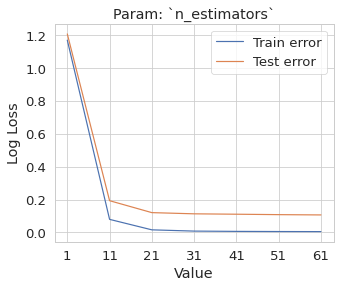

In [25]:
hyperparameter_tuning(n_estimators=range(1, 70, 10))

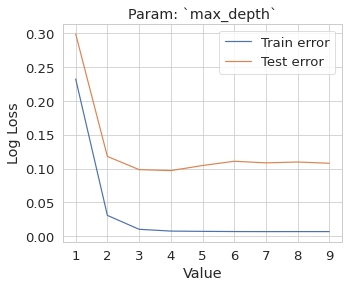

In [26]:
hyperparameter_tuning(n_estimators=40, max_depth=range(1, 10))

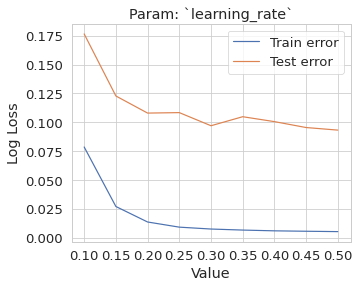

In [27]:
hyperparameter_tuning(max_depth=4, n_estimators=40, learning_rate=np.arange(0.1, 0.55, 0.05))

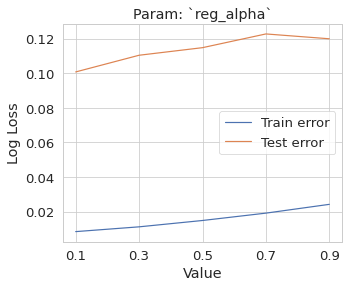

In [28]:
hyperparameter_tuning(
    max_depth=4,
    n_estimators=40,
    learning_rate=0.3,
    reg_alpha=np.arange(0.1, 1, 0.2),
)

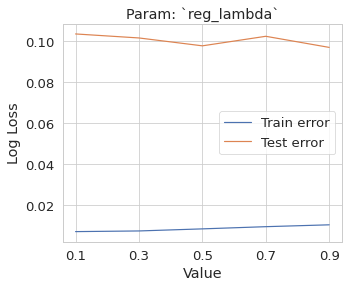

In [29]:
hyperparameter_tuning(
    max_depth=3,
    n_estimators=40,
    learning_rate=0.3,
    reg_lambda=np.arange(0.1, 1, 0.2),
)

In [30]:
grid = {
    "n_estimators": [40, 45, 50],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.35, 0.4, 0.45],
}

start = time.time()

xgb_clf1 = XGBClassifier(random_state=42, n_jobs=-1)
xgb_cvm = GridSearchCV(estimator=xgb_clf1, param_grid=grid, n_jobs=-1, cv=5)
xgb_cvm.fit(X, y, sample_weight=get_weights(y))

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [31]:
end = time.time()
print("Time taken in hyperparameter tuning:", math.ceil((end - start) / 60), "mins.")

tuned_model = xgb_cvm.best_estimator_

print("\nBest parameters:")
print(xgb_cvm.best_params_)

Time taken in hyperparameter tuning: 8 mins.

Best parameters:
{'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 45}


In [32]:
print("Accuracy:", round(xgb_cvm.best_score_, 4))

Accuracy: 0.9604


In [33]:
best_model = XGBClassifier(**xgb_cvm.best_params_, random_state=42, n_jobs=-1)
best_model.fit(X, y, sample_weight=get_weights(y))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=45,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [34]:
if os.path.exists(TS_VEC_CSV) and os.stat(TS_VEC_CSV).st_size > 0:
    print("Loading vectors from", TS_VEC_CSV)
    test_df = pd.read_csv(TS_VEC_CSV, index_col="Id")
else:
    # Get complete list of byte-files in input directory.
    _, _, ts_file_names = next(os.walk(TEST_DIR))

    # Generate list for file paths.
    ts_file_paths = [os.path.join(TEST_DIR, fn) for fn in ts_file_names]

    print(f"Test dataset contains {len(ts_file_paths)} files.")
    print("Vectorization of test dataset...")

    # Parallelized File Processing.
    ts_ftr_vecs = parallelize(vectorizer.transform_byte_file, ts_file_paths)

    # Convert vectors to DataFrame.
    test_df = pd.DataFrame(ts_ftr_vecs, columns=final_ftrs)
    test_df.set_index(["Id"], inplace=True)

    # Save DataFrame as CSV for future use.
    test_df.to_csv(TS_VEC_CSV, index_label="Id")

test_df.sample(3)

Loading vectors from ../input/microsoft-malware-sample/test_vec.csv


,BytFSize,00,01,02,03,04,05,06,07,08,...,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff
Id,,,,,,,,,,,,,,,,,,,,,
S3akQhiZwB2oTPRu9e7j,8507904,11303,5571,3165,3411,3218,3311,3339,3325,3209,...,3209,3221,3268,3255,3244,3133,3203,3171,3169,6710
KB7ybYxf95pdtUoGzl3u,8493056,11390,5480,3187,3344,3280,3283,3200,3275,3227,...,3289,3215,3174,3313,3222,3282,3198,3206,3256,6872
MHCnS9wv5Fxr6uqLDydh,8507904,11389,5489,3250,3344,3289,3264,3300,3226,3243,...,3257,3244,3124,3199,3202,3186,3243,3139,3194,6669


In [35]:
rows, cols = test_df.shape
print(f"Test dataset contains {rows} rows and {cols} columns.")

Test dataset contains 10873 rows and 257 columns.


In [36]:
predictions = np.round(best_model.predict_proba(test_df).tolist(), 1).tolist()

print("Sample rows from predictions:")
predictions[:5]

Sample rows from predictions:


[[0.0, 0.0, 0.0, 0.8, 0.0, 0.1, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.7, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]

In [37]:
data = np.column_stack((test_df.index, predictions))
col_names = ["Id"] + [f"Prediction{i}" for i in range(1, 10)]

output = pd.DataFrame(data, columns=col_names)
output.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
